In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# For windows/linux will try CUDA, for Apple devices will try MPS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def load_dataset(train_path, test_path):
    # Load and drop date column
    train_df = pd.read_csv(train_path, parse_dates=['date']).drop(columns=['date'])
    test_df = pd.read_csv(test_path, parse_dates=['date']).drop(columns=['date'])

    # Normalize using training statistics
    stats = train_df.describe().transpose()

    def normalize(df):
        return (df - stats["mean"]) / stats["std"]

    train_norm = normalize(train_df)
    test_norm = normalize(test_df)

    return train_norm, test_norm, stats

In [5]:
# Load dataset from file
train_file_path = '../dataset/train/DailyDelhiClimateTrain.csv'
test_file_path = '../dataset/test/DailyDelhiClimateTest.csv'
train_data, test_data, stats = load_dataset(train_file_path, test_file_path)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, n_inputs, n_outputs):
        self.dataframe = dataframe
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.inputs = []
        self.outputs = []
        self.define_samples()

    def define_samples(self):
        data_array = self.dataframe.values
        for i in range(len(data_array) - self.n_inputs - self.n_outputs):
            input_seq = data_array[i:i+self.n_inputs, :]         # Sequence length of 30, incl all features
            output_seq = data_array[i+self.n_inputs:i+self.n_inputs+self.n_outputs, :]  # Sequence length of 7, incl all features
            self.inputs.append(input_seq)
            self.outputs.append(output_seq)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)  # Shape: (n_inputs, 4)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32) # Shape: (n_outputs,)
        return x, y

In [7]:
n_inputs = 30
n_outputs = 7
train_dataset = CustomDataset(train_data, n_inputs, n_outputs)
test_dataset = CustomDataset(test_data, n_inputs, n_outputs)

In [8]:
# Define batch size
batch_size = 128
print(device)

# Random number generator (for reproducibility)
generator = torch.Generator()  # Defaults to CPU, which DataLoader expects

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Important: don't shuffle test data
    generator=generator
)

cpu


## 1. Step 1: Designing an Encoder model

In [9]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = False)

    def forward(self, input_seq):
        # input_seq: (seq_len, batch_size, input_size)
        output, hidden = self.gru(input_seq)
        return hidden

In [10]:
# Defining our EncoderRNN model
hidden_size = 64
encoder_model = EncoderGRU(4, hidden_size)
print(encoder_model)

EncoderGRU(
  (gru): GRU(4, 64)
)


In [11]:
# Testing our EncoderRNN model

# Grab one batch from the train dataloader
inputs, _ = next(iter(train_dataloader))  # inputs shape: (batch_size, seq_len, input_size)

# Rearrange for GRU: (seq_len, batch_size, input_size)
inputs = inputs.permute(1, 0, 2)  # (seq_len, batch_size, input_size)

print("Input shape to encoder:", inputs.shape)  # Should be (seq_len, batch_size, 4)

# Pass through encoder
encoder_out = encoder_model(inputs)

print("Encoder output (last hidden state) shape:", encoder_out.shape)  # (1, batch_size, hidden_size)
print("Sample vector:", encoder_out[0])

Input shape to encoder: torch.Size([30, 128, 4])
Encoder output (last hidden state) shape: torch.Size([1, 128, 64])
Sample vector: tensor([[-0.0991,  0.0753, -0.1473,  ..., -0.1044, -0.1332, -0.0269],
        [ 0.0768, -0.0967, -0.0423,  ..., -0.1891,  0.1644, -0.1005],
        [-0.0156, -0.0202, -0.1096,  ..., -0.1023, -0.0430,  0.0146],
        ...,
        [-0.0693,  0.0714, -0.1420,  ..., -0.1062, -0.0171, -0.1335],
        [-0.0310, -0.1305, -0.0099,  ..., -0.3070, -0.0611,  0.1380],
        [ 0.0319, -0.1515,  0.0371,  ..., -0.3550,  0.1304, -0.0332]],
       grad_fn=<SelectBackward0>)


## 2. Step 2: Designing a Decoder model

In [14]:
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, feature_size):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.feature_size = feature_size # 4 features

        self.gru = nn.GRU(input_size=feature_size, hidden_size=hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, feature_size)

    def forward(self, x, hidden, output_length, target=None):
        outputs = []
        decoder_input = x  # shape: (1, batch_size, 4)

        for i in range(output_length):
            # One step forward through GRU
            decoder_output, hidden = self.gru(decoder_input, hidden)
            decoder_output = self.linear(decoder_output)  # shape: (1, batch_size, 4)
            outputs.append(decoder_output)

            if target is not None:
                # Teacher forcing: use actual target
                decoder_input = target[i].unsqueeze(0)  # shape: (1, batch_size, 4)
            else:
                # Auto-regressive: use own prediction
                decoder_input = decoder_output.detach()  # detach to prevent gradient flow

        return torch.cat(outputs, dim=0)  # shape: (output_length, batch_size, 1)

In [16]:
# Defining our DecoderRNN model
decoder_model = DecoderGRU(hidden_size = hidden_size, feature_size = 4)
print(decoder_model)

DecoderGRU(
  (gru): GRU(4, 64)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)


In [17]:
# Testing our DecoderRNN model

# Get a batch from dataloader
inputs, _ = next(iter(train_dataloader))  # inputs: (batch_size, seq_length, input_size)

# Permute for encoder: (seq_length, batch_size, input_size)
encoder_input = inputs.permute(1, 0, 2)

# Pass through encoder
encoder_hidden = encoder_model(encoder_input)  # shape: (1, batch_size, hidden_size)

# Initial decoder input: zeros, shape (1, batch_size, 1)
decoder_input = torch.zeros(1, inputs.size(0), 4).to(encoder_input.device)

# Run decoder
decoder_output = decoder_model(decoder_input, encoder_hidden, n_outputs)

# Output shape: (T_out, B, 1)
print("Decoder output shape:", decoder_output.shape)

Decoder output shape: torch.Size([7, 128, 4])


## Step 3: Assembling everything into a Seq2Seq model.

In [18]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Seq2SeqGRU, self).__init__()
        self.output_length = output_size
        self.encoder = EncoderGRU(input_size=4, hidden_size=hidden_size)  # 4 features
        self.decoder = DecoderGRU(hidden_size=hidden_size, feature_size=4)  # 4 features

    def forward(self, inputs, outputs=None):
        """
        Args:
            inputs: shape (seq_len, batch_size, input_size=4)
            outputs: optional teacher forcing target, shape (output_length, batch_size, 1)
        """
        hidden = self.encoder(inputs)  # returns (1, batch_size, hidden_size)

        # Initial decoder input: zeros (1, batch_size, 4)
        decoder_input = torch.zeros(1, inputs.shape[1], self.decoder.feature_size).to(inputs.device)

        # Pass to decoder
        output = self.decoder(decoder_input, hidden, self.output_length, outputs)
        return output  # shape: (output_length, batch_size, 1)

In [19]:
# Defining our Seq2Seq model
seq2seq_model = Seq2SeqGRU(hidden_size = hidden_size, \
                        output_size = n_outputs)
print(seq2seq_model)

Seq2SeqGRU(
  (encoder): EncoderGRU(
    (gru): GRU(4, 64)
  )
  (decoder): DecoderGRU(
    (gru): GRU(4, 64)
    (linear): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [21]:
# Instantiate model
seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size, output_size=n_outputs).to(device)

# Get a batch from the dataloader
inputs, outputs = next(iter(train_dataloader))  # shapes: (B, T_in, 4), (B, T_out)

inputs = inputs.to(device)
outputs = outputs.to(device)

# Permute to (seq_length, batch_size, input_size)
inputs = inputs.permute(1, 0, 2)
outputs = outputs.permute(1, 0, 2)

print("Input shape:", inputs.shape)   # (input_seq_len, batch_size, 4)
print("Target shape:", outputs.shape) # (output_seq_len, batch_size, 1)

# Forward pass
seq2seq_out = seq2seq_model(inputs, outputs)

print("Output shape:", seq2seq_out.shape)  # (output_seq_len, batch_size, 1)

Input shape: torch.Size([30, 128, 4])
Target shape: torch.Size([7, 128, 4])
Output shape: torch.Size([7, 128, 4])


## Step 4: Finally, training and evaluating our Seq2Seq model

In [22]:
def train(dataloader, model, num_epochs, learning_rate, device):
    # Set model to training mode
    model.train()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, targets in dataloader:
            # Move to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape to (seq_len, batch_size, input_size)
            inputs = inputs.permute(1, 0, 2)  # (T_in, B, 4)
            targets = targets.permute(1, 0, 2)  # (T_out, B, 4)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with teacher forcing
            predictions = model(inputs, targets)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Print loss periodically
        if (epoch + 1) % 25 == 0 or epoch == 0:
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

In [ ]:
# Step 1: Initial training (save baseline state)
hidden_size = 64
seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size, output_size=n_outputs).to(device)

# Run training for warm-up
%timeit -r 1 -n 1 train( dataloader=train_dataloader, model=seq2seq_model, num_epochs=51, learning_rate=1e-3, device=device)

# Save this state for reuse
torch.save(seq2seq_model.state_dict(), 'seq2seq_autoregressive_gru_start.pth')

Epoch 1/51, Avg Loss: 0.9055
Epoch 25/51, Avg Loss: 0.4865
Epoch 50/51, Avg Loss: 0.4583
20.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
# Step 2: Reload and train further from saved state
hidden_size = 64
seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size, output_size=n_outputs).to(device)

# Load saved model weights
seq2seq_model.load_state_dict(torch.load('seq2seq_gru_model_start.pth', map_location=device))

# Continue training
%timeit -r 1 -n 1 train(dataloader=train_dataloader, model=seq2seq_model,num_epochs=1051,learning_rate=1e-3, device=device)

Epoch 1/1051, Avg Loss: 0.4620
Epoch 25/1051, Avg Loss: 0.4621
Epoch 50/1051, Avg Loss: 0.2791
Epoch 75/1051, Avg Loss: 0.2335
Epoch 100/1051, Avg Loss: 0.2097
Epoch 125/1051, Avg Loss: 0.1941
Epoch 150/1051, Avg Loss: 0.1791
Epoch 175/1051, Avg Loss: 0.1634
Epoch 200/1051, Avg Loss: 0.1522
Epoch 225/1051, Avg Loss: 0.1405
Epoch 250/1051, Avg Loss: 0.1683
Epoch 275/1051, Avg Loss: 0.1260
Epoch 300/1051, Avg Loss: 0.1227
Epoch 325/1051, Avg Loss: 0.1118
Epoch 350/1051, Avg Loss: 0.1057
Epoch 375/1051, Avg Loss: 0.1291
Epoch 400/1051, Avg Loss: 0.1038
Epoch 425/1051, Avg Loss: 0.0937
Epoch 450/1051, Avg Loss: 0.0901
Epoch 475/1051, Avg Loss: 0.0872
Epoch 500/1051, Avg Loss: 0.0855
Epoch 525/1051, Avg Loss: 0.0787
Epoch 550/1051, Avg Loss: 0.0796
Epoch 575/1051, Avg Loss: 0.0768
Epoch 600/1051, Avg Loss: 0.1190
Epoch 625/1051, Avg Loss: 0.0702
Epoch 650/1051, Avg Loss: 0.0687
Epoch 675/1051, Avg Loss: 0.0693
Epoch 700/1051, Avg Loss: 0.0633
Epoch 725/1051, Avg Loss: 0.0684
Epoch 750/1051,

In [ ]:
# Do not uncomment and execute, this was used to prepare the model that you will be using in the final question!
torch.save(seq2seq_model.state_dict(), 'seq2seq_autoregressive_gru_end.pth')

In [26]:
def test_model(model, dataloader, seed_value):
    model.eval()
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)

    inputs, outputs = next(iter(dataloader))
    inputs = inputs.to(device)
    outputs = outputs.to(device)

    inputs_seq = inputs.permute(1, 0, 2)
    outputs_seq = outputs.permute(1, 0, 2)

    pred = model(inputs_seq)

    true_vals = outputs_seq.cpu().numpy()[:, 0, :]
    pred_vals = pred.detach().cpu().numpy()[:, 0, :]

    print("Ground truth:\n", true_vals.T)
    print("Prediction:\n", pred_vals.T)
    print("MAE:", np.mean(np.abs(true_vals - pred_vals)))

    feature_mae = np.mean(np.abs(true_vals - pred_vals), axis=(0, 1))
    print("Feature-wise MAE:", feature_mae)

In [ ]:
# Load and evaluate the trained GRU-based Seq2Seq model
hidden_size = 64
seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size, output_size=n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_autoregressive_gru_end.pth', map_location=device))

seed_value = 187
test_model(seq2seq_model, test_dataloader, seed_value)

Ground truth:
 [[-1.2752299  -1.3943083  -1.1437798  -1.3417282  -0.9247994  -0.93411076
  -1.1712726 ]
 [ 0.9080867   1.0646194   0.3442977   1.0381919   1.0034971   1.0053803
   0.53042036]
 [-0.47729036 -0.37316027 -0.82754606 -1.0846328   0.6615639   0.28450337
   0.49154565]
 [ 0.02438779  0.03548462  0.04330284  0.03674562  0.01828454  0.01723326
   0.027162  ]]
Prediction:
 [[-1.0759475  -1.0932512  -1.0872455  -1.0039301  -1.0078423  -0.96614146
  -0.9778413 ]
 [ 0.545094    0.4458989   0.53581643  0.35852724  0.49622288  0.48272315
   0.5661551 ]
 [-0.5585115  -0.2920482  -0.4810191  -0.25069013 -0.3943157  -0.34727374
  -0.2741234 ]
 [ 0.26297826 -0.06137764 -0.07168323 -0.24793404 -0.2913006  -0.2360987
  -0.08496839]]
MAE: 0.33314404
Feature-wise MAE: 0.33314404


In [31]:
import matplotlib.pyplot as plt

In [56]:
def visualize_some_predictions(model, dataloader, device, stats=None, indices=[2486, 2986, 3486, 3986]):
    feature_names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
    model.eval()
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    for ax, seed in zip(axs.flatten(), indices):
        g = torch.Generator()
        g.manual_seed(seed)

         # Rebuild DataLoader with shuffled batches per seed
        data_iter = iter(torch.utils.data.DataLoader(
            dataloader.dataset, batch_size=32, shuffle=True, generator=g
        ))

        inputs, outputs = next(data_iter)
        inputs, outputs = inputs.to(device), outputs.to(device)

        inputs_seq = inputs.permute(1, 0, 2)      # (T_in, B, 4)
        outputs_seq = outputs.permute(1, 0, 2)    # (T_out, B, 4)
        preds = model(inputs_seq)                # (T_out, B, 4)

        b = 0  # or any number < inputs.size(0)

        x = inputs[b].detach().cpu().numpy()         # shape: (T_in, 4)
        y_true = outputs_seq[:, b, :].detach().cpu().numpy()  # (T_out, 4)
        y_pred = preds[:, b, :].detach().cpu().numpy()    # (T_out, 4)

        print(f"x shape: {x.shape}, y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
        # Denormalize if stats provided
        if stats is not None:
            for i, name in enumerate(feature_names):
                mean = stats.loc[name, 'mean']
                std = stats.loc[name, 'std']
                x[:, i] = x[:, i] * std + mean
                y_true[:, i] = y_true[:, i] * std + mean
                y_pred[:, i] = y_pred[:, i] * std + mean

        # Plot predictions for each feature
        t1 = list(range(x.shape[0]))
        t2 = [x.shape[0]]
        t3 = [x.shape[0] + i + 1 for i in range(y_true.shape[0])]

        for i in range(4):
            ax.plot(t1, x[:, i], label=f"Input {feature_names[i]}", linestyle="--")
            ax.scatter(t3, y_true[:, i], label=f"True {feature_names[i]}", alpha=0.7)
            ax.scatter(t3, y_pred[:, i], label=f"Pred {feature_names[i]}", marker='x')

        mse = np.mean((y_true - y_pred) ** 2)
        ax.set_title(f"Sample seed={seed} | MSE={mse:.4f}")
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        ax.grid(True)

    plt.tight_layout()
    plt.show()

x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)
x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)
x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)
x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)


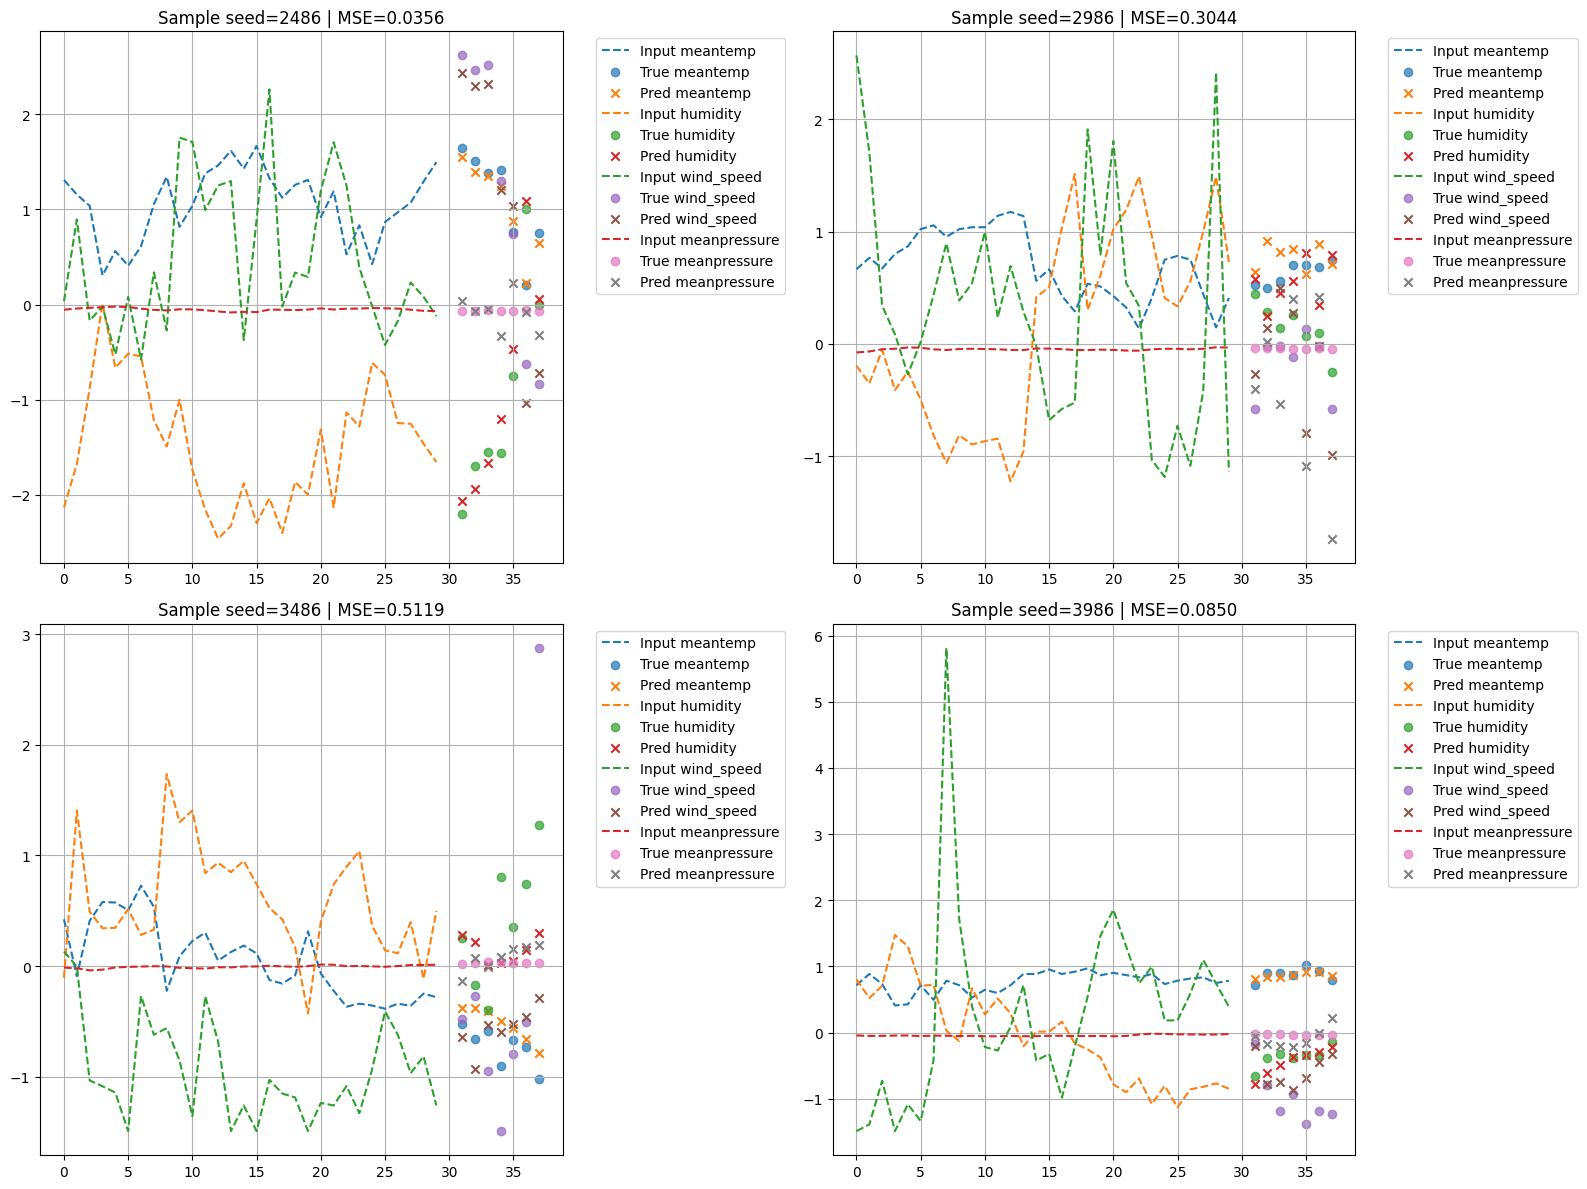

In [ ]:
hidden_size = 64
seq2seq_model = Seq2SeqGRU(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_autoregressive_gru_end.pth'))
# Visualize
visualize_some_predictions(seq2seq_model, train_dataloader, device)

In [ ]:
# Load and evaluate the trained GRU-based Seq2Seq model
hidden_size = 64
seq2seq_model = Seq2SeqGRU(hidden_size=hidden_size, output_size=n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_autoregressive_gru_end.pth', map_location=device))

seed_value = 187
test_model(seq2seq_model, test_dataloader, seed_value)

Ground truth:
 [[-1.2752299  -1.3943083  -1.1437798  -1.3417282  -0.9247994  -0.93411076
  -1.1712726 ]
 [ 0.9080867   1.0646194   0.3442977   1.0381919   1.0034971   1.0053803
   0.53042036]
 [-0.47729036 -0.37316027 -0.82754606 -1.0846328   0.6615639   0.28450337
   0.49154565]
 [ 0.02438779  0.03548462  0.04330284  0.03674562  0.01828454  0.01723326
   0.027162  ]]
Prediction:
 [[-1.0759475  -1.0932512  -1.0872455  -1.0039301  -1.0078423  -0.96614146
  -0.9778413 ]
 [ 0.545094    0.4458989   0.53581643  0.35852724  0.49622288  0.48272315
   0.5661551 ]
 [-0.5585115  -0.2920482  -0.4810191  -0.25069013 -0.3943157  -0.34727374
  -0.2741234 ]
 [ 0.26297826 -0.06137764 -0.07168323 -0.24793404 -0.2913006  -0.2360987
  -0.08496839]]
MAE: 0.33314404
Feature-wise MAE: 0.33314404


x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)
x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)
x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)
x shape: (30, 4), y_true shape: (7, 4), y_pred shape: (7, 4)


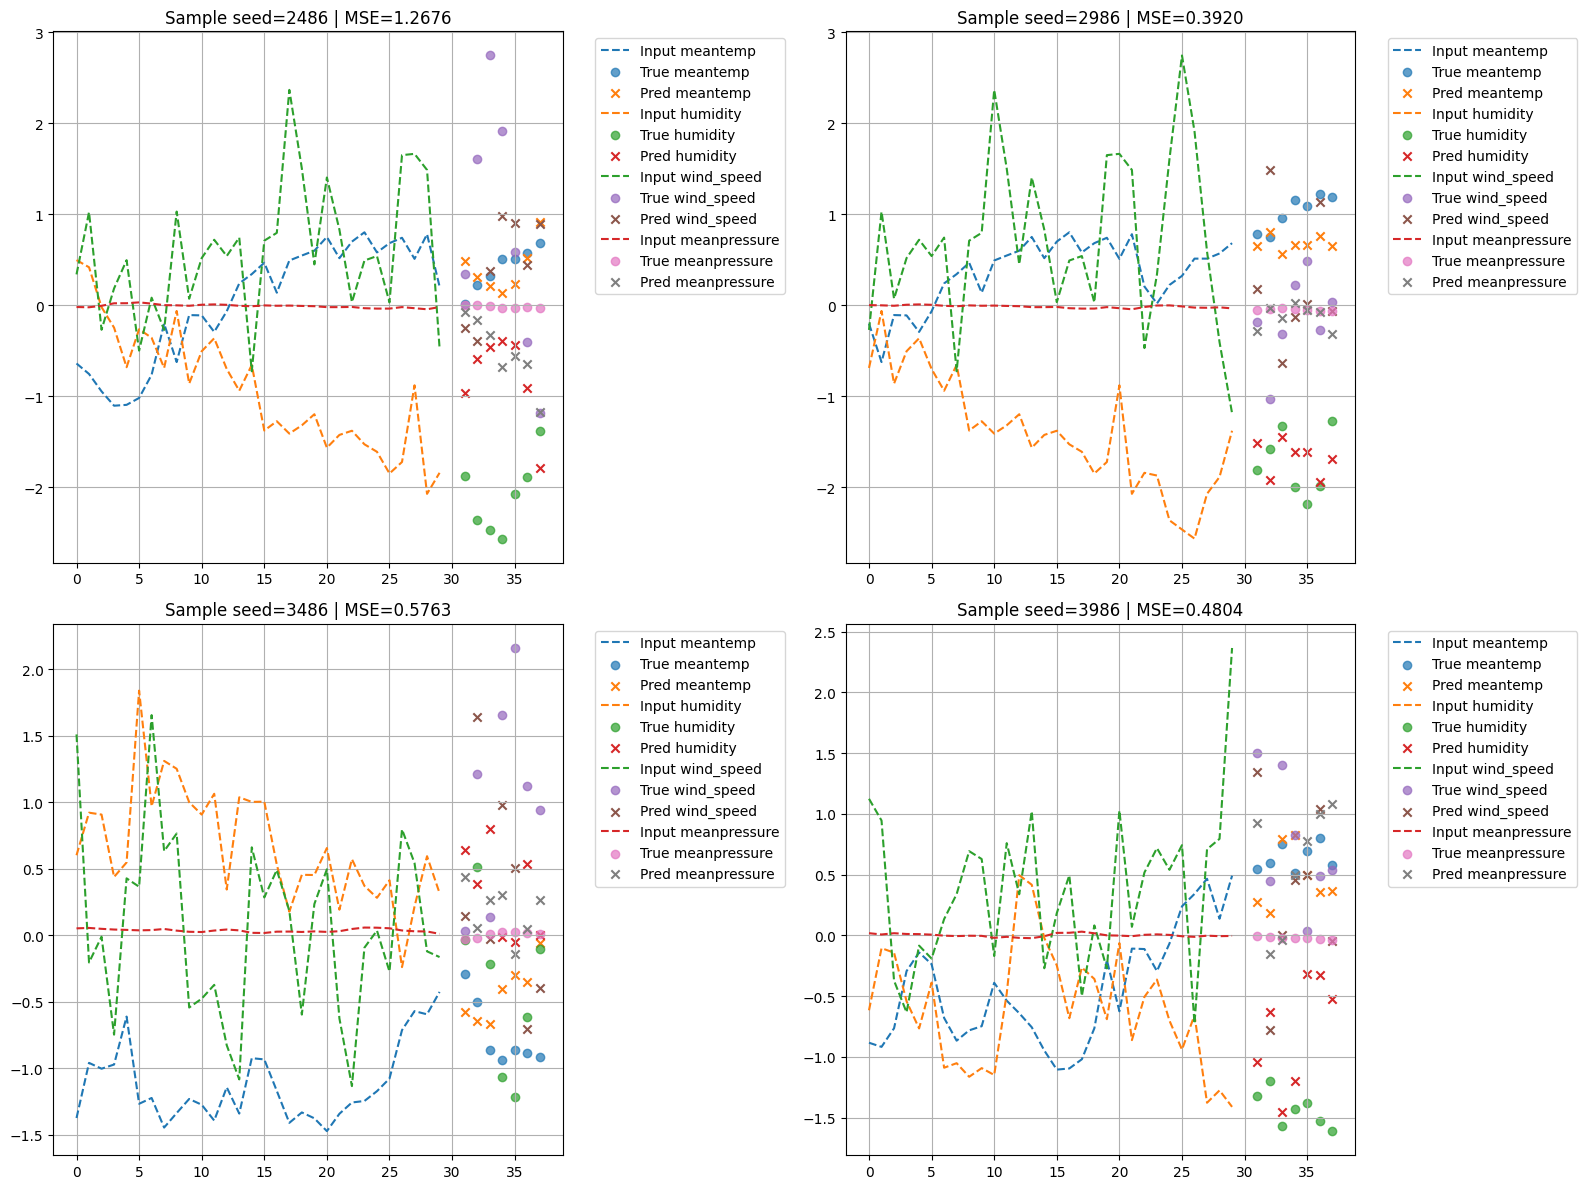

In [ ]:
hidden_size = 64
seq2seq_model = Seq2SeqGRU(hidden_size = hidden_size, \
                        output_size = n_outputs).to(device)
seq2seq_model.load_state_dict(torch.load('seq2seq_autoregressive_gru_end.pth'))
# Visualize
visualize_some_predictions(seq2seq_model, test_dataloader, device)

In [47]:
# def evaluate_on_test_set(model, dataloader, device, stats=None):
#     model.eval()
#     mae_total = 0
#     mse_total = 0
#     count = 0

#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs = inputs.to(device)
#             targets = targets.to(device)

#             # Reshape: (T_in, B, 4), (T_out, B, 1)
#             inputs_seq = inputs.permute(1, 0, 2)
#             targets_seq = targets.unsqueeze(-1).permute(1, 0, 2)

#             preds = model(inputs_seq)  # shape: (T_out, B, 1)

#             # Optionally denormalize if stats provided
#             if stats is not None:
#                 mean = stats.loc["meantemp", "mean"]
#                 std = stats.loc["meantemp", "std"]

#                 preds = preds * std + mean
#                 targets_seq = targets_seq * std + mean

#             mae = torch.mean(torch.abs(preds - targets_seq)).item()
#             mse = torch.mean((preds - targets_seq) ** 2).item()

#             mae_total += mae * inputs.size(0)
#             mse_total += mse * inputs.size(0)
#             count += inputs.size(0)

#     print(f"Evaluation on Test Set:")
#     print(f"MAE: {mae_total / count:.4f}")
#     print(f"MSE: {mse_total / count:.4f}")

In [ ]:
# evaluate_on_test_set(
#     model=seq2seq_model,
#     dataloader=test_dataloader,
#     device=device,
#     stats=stats  # Pass this only if you want to denormalize
# )

Evaluation on Test Set:
MAE: 2.5698
MSE: 9.7615


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# def visualize_some_predictions(model, dataloader, device, stats=None, seed_values=[2486, 2986, 3486, 3986]):
#     """
#     Visualizes predictions for a few random samples from the dataloader.

#     Args:
#         model: Trained Seq2SeqGRU model
#         dataloader: DataLoader (train or test)
#         device: torch.device
#         stats: Optional normalization stats (pass to denormalize)
#         seed_values: List of seed values to control randomness
#     """
#     model.eval()
#     fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#     for ax, seed in zip(axs.flatten(), seed_values):
#         # Set seeds for reproducibility
#         torch.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)
#         np.random.seed(seed)

#         # Get a random batch
#         inputs, targets = next(iter(dataloader))
#         inputs, targets = inputs.to(device), targets.to(device)

#         # Prepare inputs for the model
#         inputs_seq = inputs.permute(1, 0, 2)  # (T_in, B, 4)
#         targets_seq = targets.unsqueeze(-1).permute(1, 0, 2)  # (T_out, B, 1)

#         # Predict
#         preds = model(inputs_seq)

#         # Randomly select one sample from the batch
#         b = np.random.randint(0, inputs.size(0))
#         x = inputs[b, :, 0].detach().cpu().numpy()       # meantemp only
#         y_true = targets[b].detach().cpu().numpy()
#         y_pred = preds[:, b, 0].detach().cpu().numpy()

#         # Denormalize if stats are provided
#         if stats is not None:
#             mean = stats.loc["meantemp", "mean"]
#             std = stats.loc["meantemp", "std"]
#             x = x * std + mean
#             y_true = y_true * std + mean
#             y_pred = y_pred * std + mean

#         # Time steps
#         t1 = list(range(len(x)))
#         t2 = [len(x)]
#         t3 = [len(x) + i + 1 for i in range(len(y_true))]

#         ax.scatter(t1, x, label="Inputs (meantemp)", c="b")
#         ax.scatter(t2, [x[-1]], label="Last Input", c="g")
#         ax.scatter(t3, y_true, label="Ground Truth", c="r")
#         ax.scatter(t3, y_pred, label=f"Prediction (MSE={np.mean((y_true - y_pred)**2):.4f})", c="c", marker="x")
#         ax.plot(t1 + t2 + t3, np.hstack([x, [x[-1]], y_true]), "k--")
#         ax.legend()
#         ax.set_title(f"Seed: {seed}")

#     plt.tight_layout()
#     plt.show()

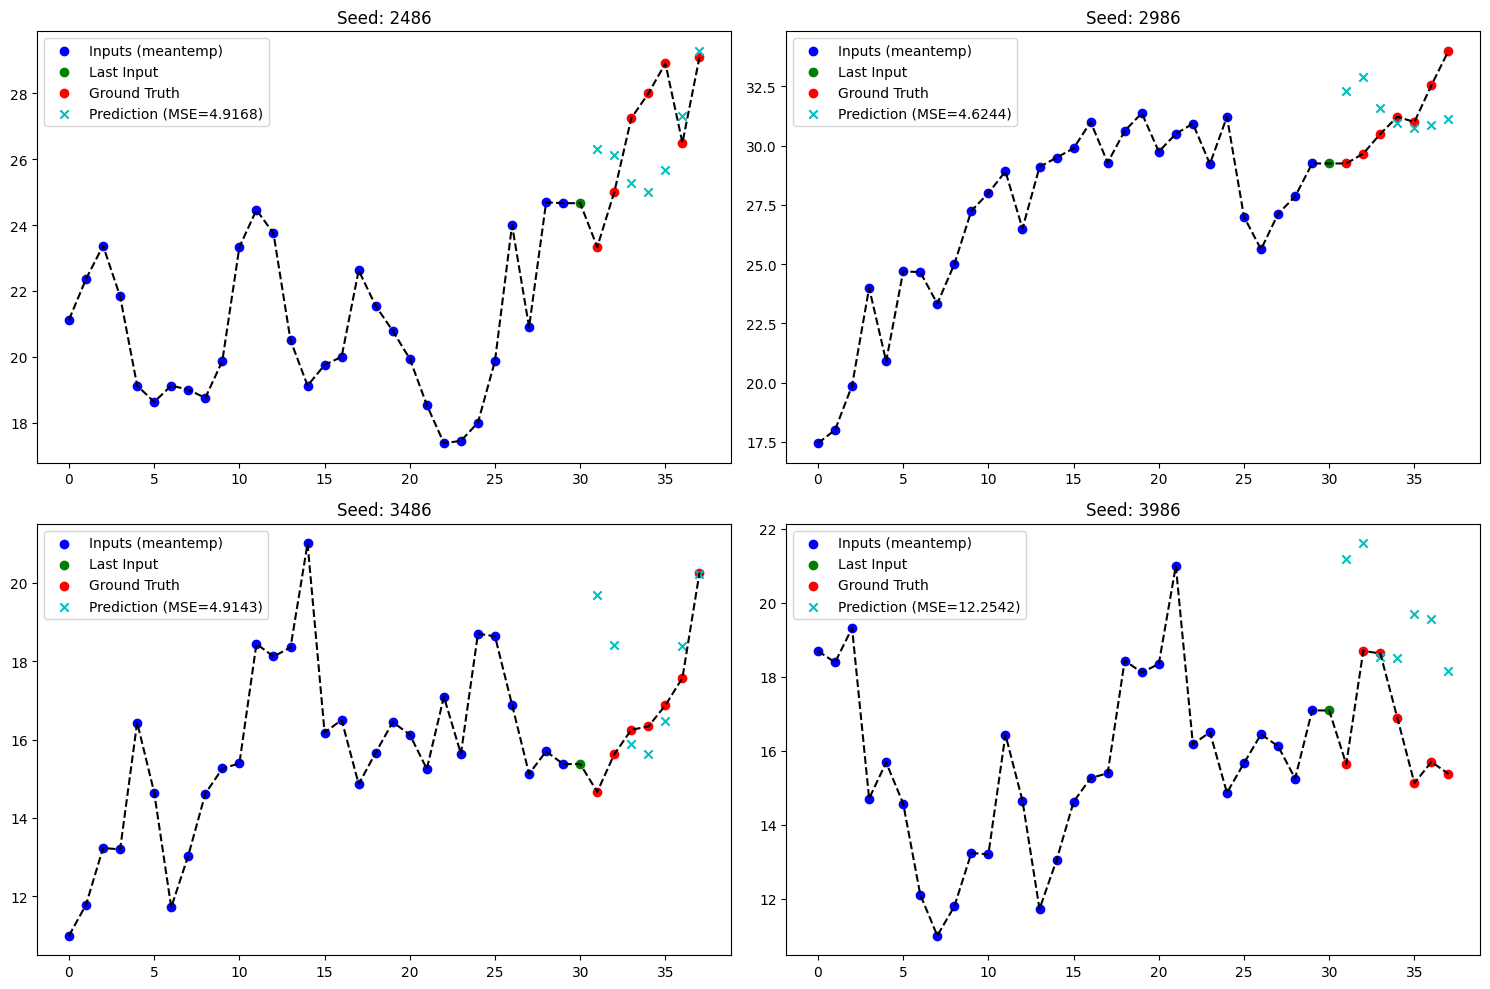

In [ ]:
# visualize_some_predictions(
#     model=seq2seq_model,
#     dataloader=test_dataloader,
#     device=device,
#     stats=stats  # Optional: pass for denormalized plots
# )